In [2]:
import sys
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20, 'display.max_columns', 50)
import h5py
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import re

In [3]:
sys.path.append(os.getcwd() + "/../../cds-backend/code/")
import cds_eua4 as eua

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (16, 9)

no config found


In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


## outlier calculation

Q1 = df.quartile(0.25)
Q3 = df.quartile(0.75)   
   
IQR = Q3 - Q1

whis = 1.5 (default)

It's an outlier if it is less than:

Q1 - whis * IQR

or if it is greater than:

Q3 + whis * IQR


## Resort report_id for Meisei data

In [5]:
def find_gap(df, group_name, delta):
    singleseries = df
    singleseries['gap'] = singleseries[group_name].sort_values().diff() > delta
    return singleseries[singleseries.gap]

In [6]:
with eua.CDMDataset(glob.glob("/scratch/das/federico/INTERCOMPARISON_MAURITIUS/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc")[0]) as file:
    display(file)
    df_meis = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    
df_meis = df_meis.sort_values(by='date_time')
gaps = find_gap(df = df_meis, group_name = 'date_time', delta = pd.to_timedelta('1 hour'))

rep_id = []
rid = 1
for i in gaps.date_time:
    byte_rid = [x.encode() for x in str(rid).zfill(10)]
    #byte_rid = [str(rid).zfill(10).encode()]
    rep_id.extend([byte_rid] * (len(df_meis[df_meis.date_time < i])-len(rep_id)))
    #rep_id.extend([str(rid).zfill(10)]* (len(df_meis[df_meis.date_time < i])-len(rep_id)))
    rid += 1
byte_rid = [x.encode() for x in str(rid).zfill(10)]
#byte_rid = [str(rid).zfill(10).encode()]
rep_id.extend([byte_rid] * (len(df_meis)-len(rep_id)))


sys.path.append("../../trajectory/")
from harvest_convert_to_netCDF import write_dict_h5

mode='w'
targetfile = '/users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc'
group = 'observations_table'

i = 'report_id'

with h5py.File(targetfile,  "a") as f:
    try:
        del f[group][i]
    except:
        pass
# ov_vars = np.array(rep_id)
alldict = {i:np.array(rep_id, dtype='S1')}
# alldict = pd.DataFrame({i:ov_vars})
write_dict_h5(targetfile, alldict, group, {i: {'compression': 'gzip'} }, [i]) 

log = ! h5repack -v GZIP=5 {targetfile} {targetfile}


File: <HDF5 file "0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc" (mode r)>
Filesize: 10.86 MB
Filename: /scratch/das/federico/INTERCOMPARISON_MAURITIUS/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc
(G)roups/(V)ariables: 

 - G | crs__________________________________________ : : 4
 - V | dateindex____________________________________ : : (9,)
 - G | header_table_________________________________ : : 54
 - G | observations_table___________________________ : : 52
 - G | observed_variable____________________________ : : 9
 - V | recordindex__________________________________ : : (250268,)
 - V | recordtimestamp______________________________ : : (250268,)
 - G | sensor_configuration_________________________ : : 0
 - G | source_configuration_________________________ : : 32
 - G | station_configuration________________________ : : 44
 - G | station_configuration_codes__________________ : : 7
 - G | station_type_________________________________ : : 4
 - G | units___________

In [7]:
with h5py.File(targetfile,  "r") as f:
    display(f.keys())
    print(f['observations_table']['report_id'][:])
    print(f['observations_table']['sensor_id'][:])

<KeysViewHDF5 ['crs', 'dateindex', 'header_table', 'observations_table', 'observed_variable', 'recordindex', 'recordtimestamp', 'sensor_configuration', 'source_configuration', 'station_configuration', 'station_configuration_codes', 'station_type', 'units', 'z_coordinate_type']>

[[b'0' b'0' b'0' ... b'0' b'0' b'1']
 [b'0' b'0' b'0' ... b'0' b'0' b'1']
 [b'0' b'0' b'0' ... b'0' b'0' b'1']
 ...
 [b'0' b'0' b'0' ... b'0' b'4' b'2']
 [b'0' b'0' b'0' ... b'0' b'4' b'2']
 [b'0' b'0' b'0' ... b'0' b'4' b'2']]
[[b'n' b'a' b'n' ... b'' b'' b'']
 [b'n' b'a' b'n' ... b'' b'' b'']
 [b'n' b'a' b'n' ... b'' b'' b'']
 ...
 [b'n' b'a' b'n' ... b'' b'' b'']
 [b'n' b'a' b'n' ... b'' b'' b'']
 [b'n' b'a' b'n' ... b'' b'' b'']]


## CUON Data

In [8]:
out = {}
for i in ['plev', 'RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate']:
    out[i] = []
rq = {
    "statid": "11035",
    
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],# "wind_speed", "geopotential"],
    "format": "nc",
    "optional": ['obs_minus_an','obs_minus_bg', 'bias_estimate_method', 'RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate',],
    # "dummy": str(np.random.rand()),
}
dl = eua.vm_request_wrapper(rq, overwrite=True)# , vm_url="http://127.0.0.1:8007")
df_all = dl.to_dataframe()

In [9]:
df_in = df_all.copy()[df_all.plev.isin(range(5000, 90000,5000))]
df_in['plev'] = df_in['plev'].apply(str)

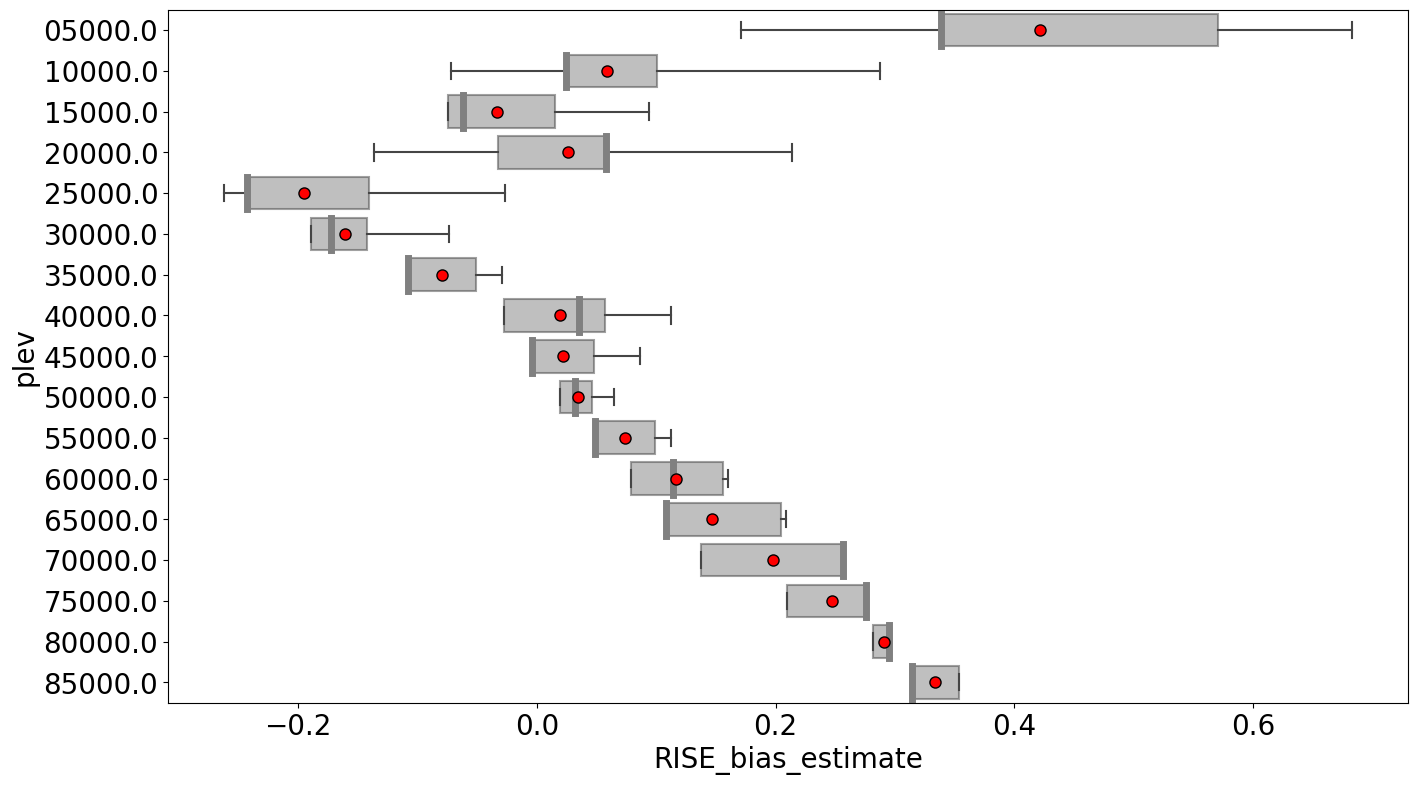

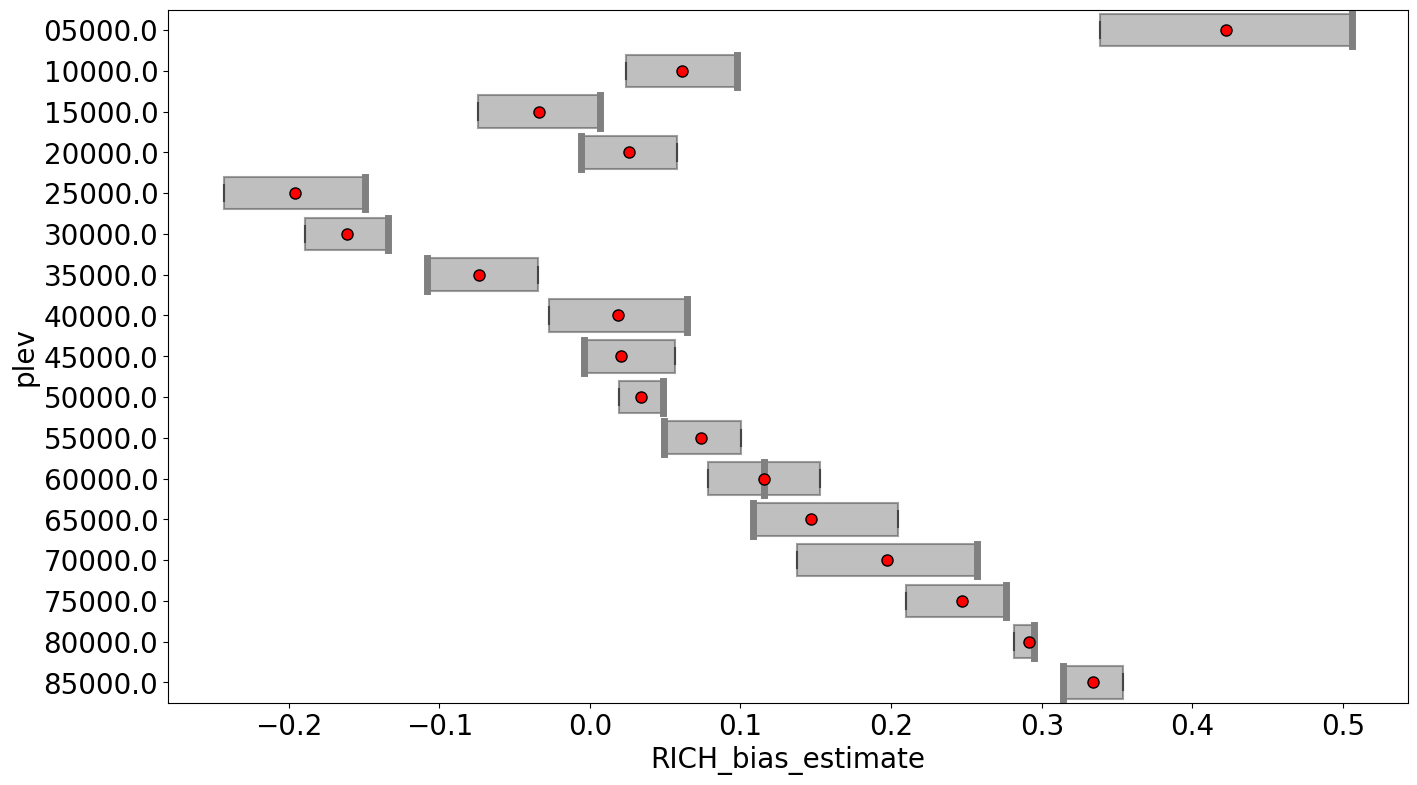

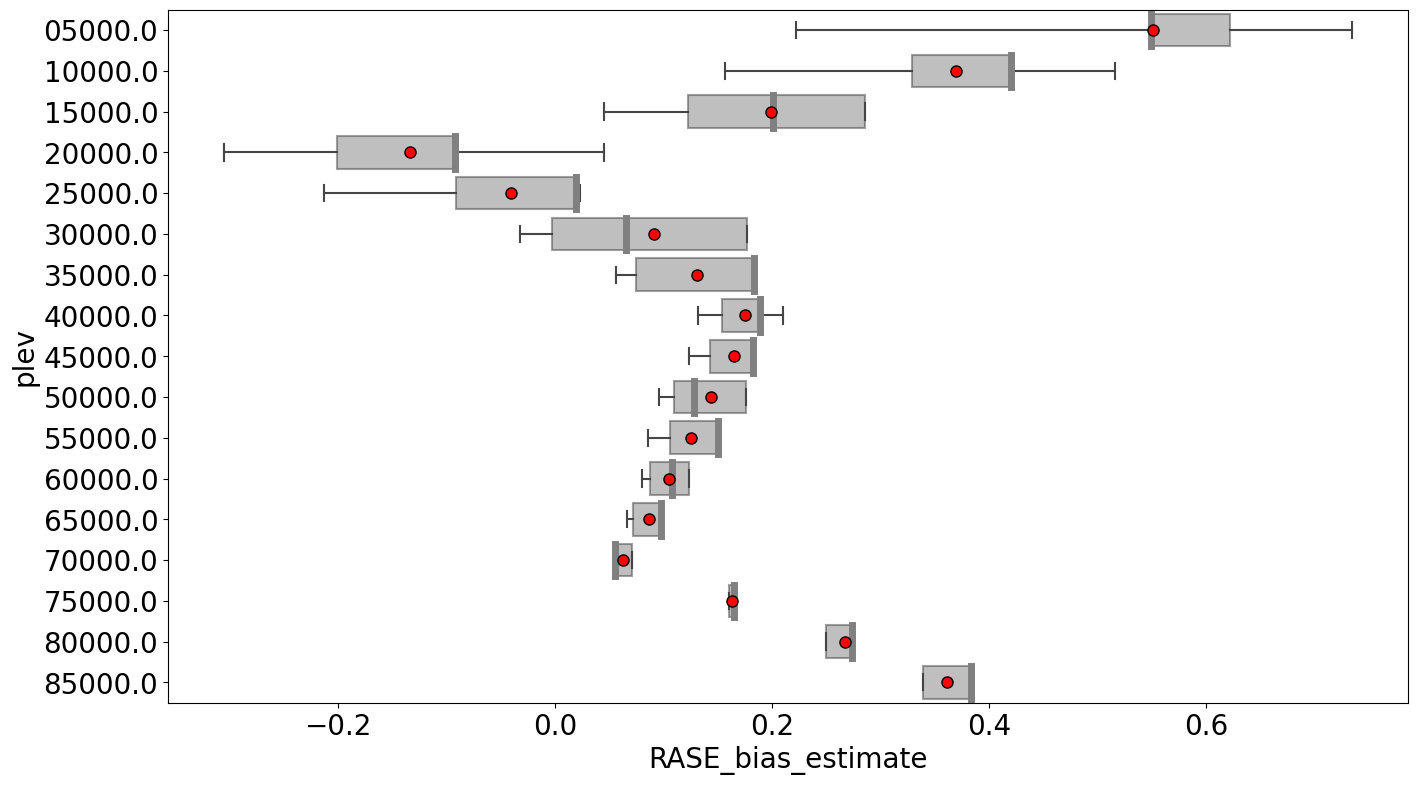

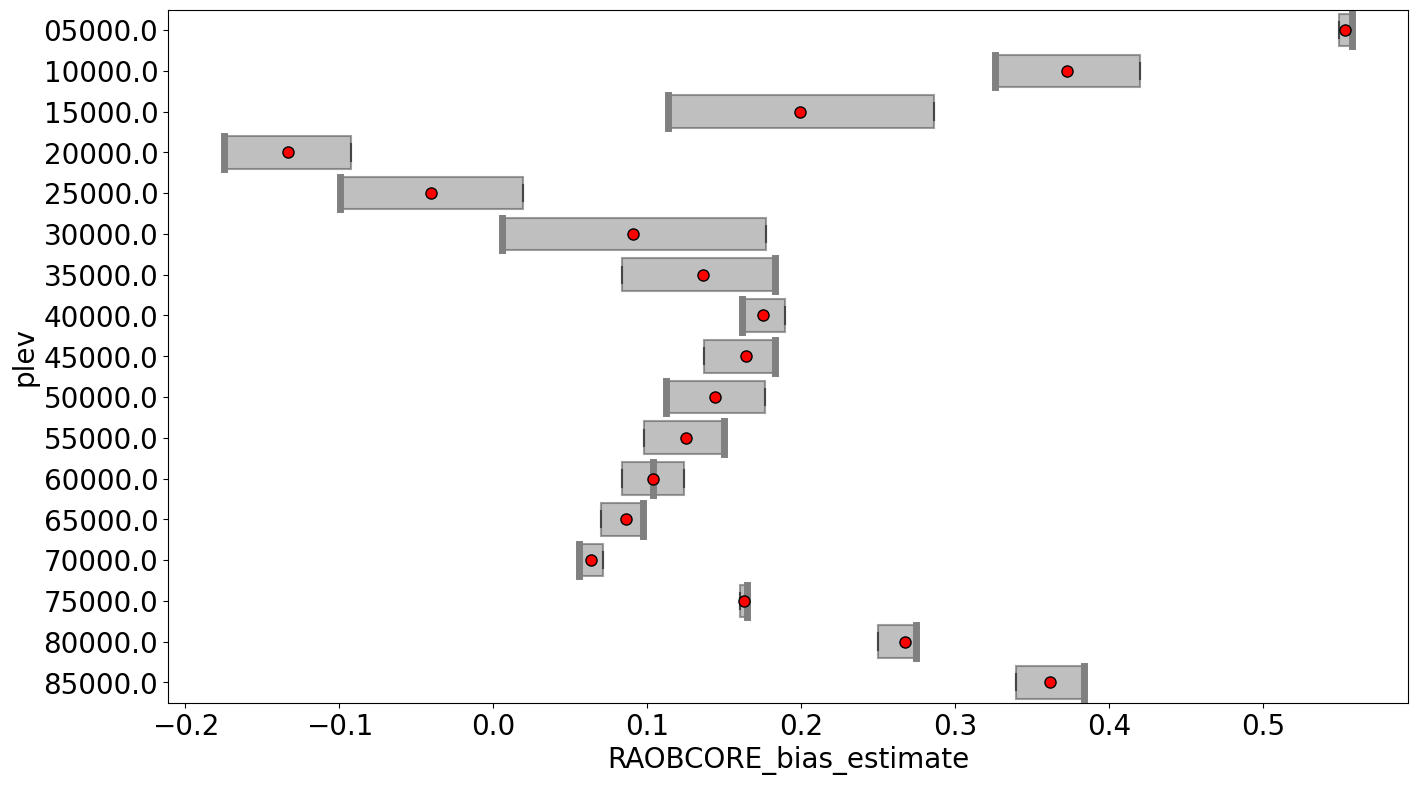

In [10]:
df_in.plev = df_in.plev.str.zfill(7)
df_in = df_in.sort_values(by='plev')
for i in ['RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate',]:
    seaborn.boxplot(
        data=df_in, x=i, y="plev",
        notch=False, showcaps=True, showfliers=True, 
        dodge=False, showmeans=True,
        boxprops={"facecolor": 'grey', "alpha":0.5},
        medianprops={"color": 'grey', "linewidth" : 5},
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
        whis=np.inf,
        # whis=1.5,
    )
    plt.show()
    plt.close()



In [11]:
# rq = {
#     "statid": "11035",
    
#     "date": ["20050101-20051231"],
#     "variable": ["relative_humidity"],# "wind_speed", "geopotential"],
#     "format": "nc",
#     "optional": ['humidity_bias_estimate',],
#     # "dummy": str(np.random.rand()),
# }
# dl = eua.vm_request_wrapper(rq, overwrite=True)# , vm_url="http://127.0.0.1:8007")
# df = dl.to_dataframe()

# df = df[df.plev == 30000]

# hist_data = []
# for i in ['humidity_bias_estimate']:# 'obs_minus_an','obs_minus_bg']:
#     hist_data.append(df[i].dropna())
#     ax = seaborn.histplot(hist_data[-1], label = i, kde=True, bins=70)
# ax.set(xlabel='Adjustments')
# plt.legend() 
# plt.show()

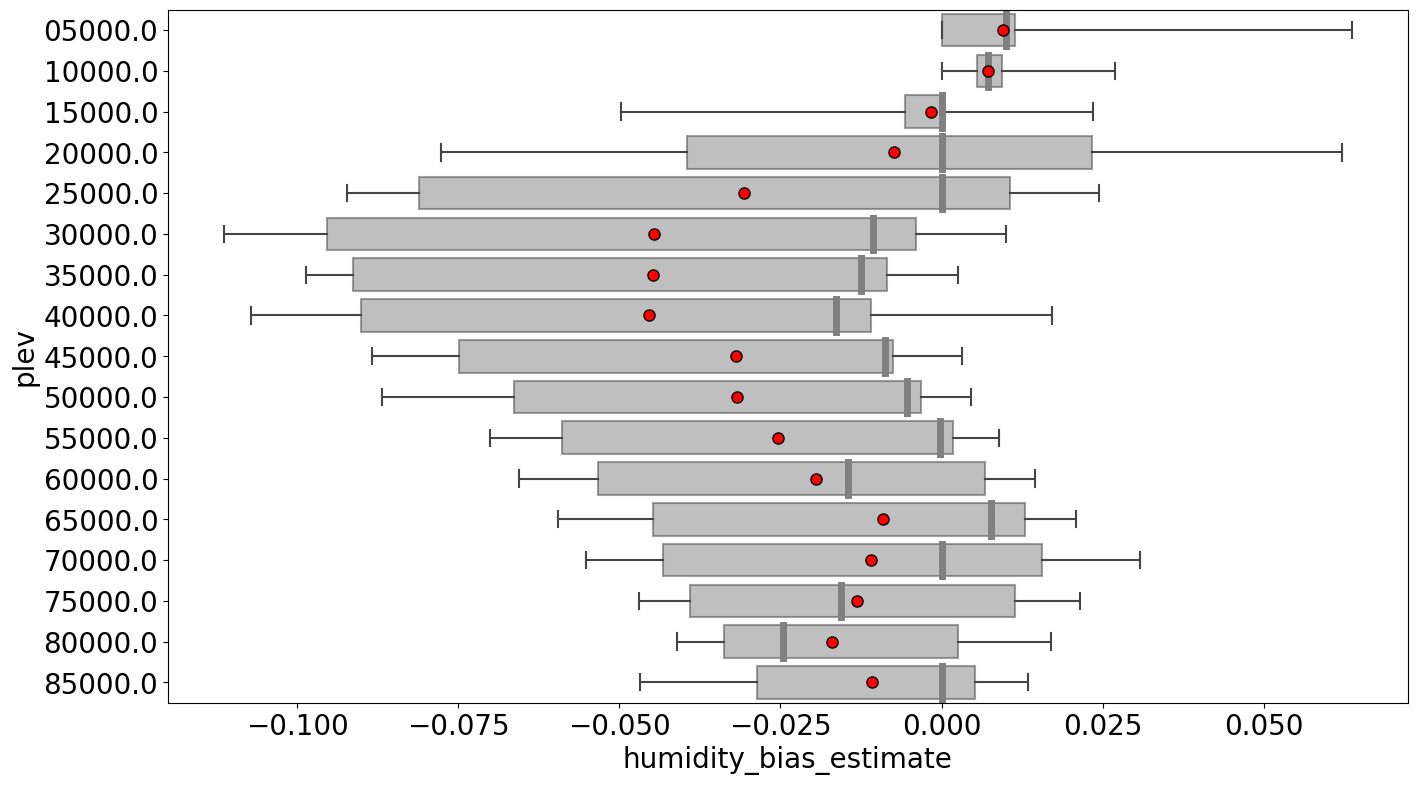

In [12]:
rq = {
    "statid": "11035",
    
    "date": ["20050101-20051231"],
    "variable": ["relative_humidity"],# "wind_speed", "geopotential"],
    "format": "nc",
    "optional": ['humidity_bias_estimate'],
    # "dummy": str(np.random.rand()),
}
df = eua.vm_request_wrapper(rq, overwrite=True)# , vm_url="http://127.0.0.1:8007")
df_all = df.to_dataframe()

df_in = df_all.copy()[df_all.plev.isin(range(5000, 90000,5000))]
df_in['plev'] = df_in['plev'].apply(str)

df_in.plev = df_in.plev.str.zfill(7)
df_in = df_in.sort_values(by='plev')

for i in zip(['humidity_bias_estimate',], ['grey']):
    seaborn.boxplot(
        data=df_in, x=i[0], y="plev",
        notch=False, showcaps=True, showfliers=True, 
        dodge=False,
        boxprops={"facecolor": i[1], "alpha":0.5},
        medianprops={"color": i[1], "linewidth" : 5},
        whis=np.inf,
        # whis=1.5,
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
    )
    plt.show()
    plt.close()

## Mauritius Data

In [13]:
with eua.CDMDataset(glob.glob("/users/staff/uvoggenberger/scratch/mauritius/*vais*.nc")[0]) as file:
    display(file)
    df_vais = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    df_vais = df_vais[df_vais.observed_variable == 126]
with eua.CDMDataset('/users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc') as file:
    display(file)
    df_meis = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    df_meis = df_meis[df_meis.observed_variable == 126]


File: <HDF5 file "0-20000-0-61995_mauritius_harvested_vaisala_ascents.csv.nc" (mode r)>
Filesize: 5.95 MB
Filename: /users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_vaisala_ascents.csv.nc
(G)roups/(V)ariables: 

 - G | crs__________________________________________ : : 4
 - V | dateindex____________________________________ : : (9,)
 - G | header_table_________________________________ : : 54
 - G | observations_table___________________________ : : 52
 - G | observed_variable____________________________ : : 9
 - V | recordindex__________________________________ : : (56,)
 - V | recordtimestamp______________________________ : : (56,)
 - G | sensor_configuration_________________________ : : 0
 - G | source_configuration_________________________ : : 32
 - G | station_configuration________________________ : : 44
 - G | station_configuration_codes__________________ : : 7
 - G | station_type_________________________________ : : 4
 - G | units_____________________

File: <HDF5 file "0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc" (mode r)>
Filesize: 11.66 MB
Filename: /users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc
(G)roups/(V)ariables: 

 - G | crs__________________________________________ : : 4
 - V | dateindex____________________________________ : : (9,)
 - G | header_table_________________________________ : : 54
 - G | observations_table___________________________ : : 53
 - G | observed_variable____________________________ : : 9
 - V | recordindex__________________________________ : : (250268,)
 - V | recordtimestamp______________________________ : : (250268,)
 - G | sensor_configuration_________________________ : : 0
 - G | source_configuration_________________________ : : 32
 - G | station_configuration________________________ : : 44
 - G | station_configuration_codes__________________ : : 7
 - G | station_type_________________________________ : : 4
 - G | units______________

In [14]:
out = {'Difference':[], 'plev': []}
diffs = []
for i in df_vais.date_time.drop_duplicates():
    # print(i.date())
    meis_time = df_meis[df_meis.date_time.dt.date == i.date()]
    for j in meis_time.report_id.drop_duplicates():
        mt = meis_time[meis_time.report_id == j].date_time.iloc[0]
        dh = float((i-mt)/ np.timedelta64(1, 'h'))
        if np.logical_and( dh < -3, dh > -5):
            # print(i, mt, "delta hours: ", dh)
            # print(j)
            # print()
            m_data = df_meis[df_meis.report_id == j]
            v_data = df_vais[df_vais.date_time == i]
            for plev in range(5000, 90000,5000):
                diffs.append(v_data[v_data.z_coordinate == find_nearest(v_data.z_coordinate, plev)].iloc[0].observation_value - m_data[m_data.z_coordinate == find_nearest(m_data.z_coordinate, plev)].iloc[0].observation_value)
                out['Difference'].append(diffs[-1])
                out['plev'].append(str(plev))

# if len(meis_time) > 0:
#     print(meis_time.report_id.drop_duplicates())

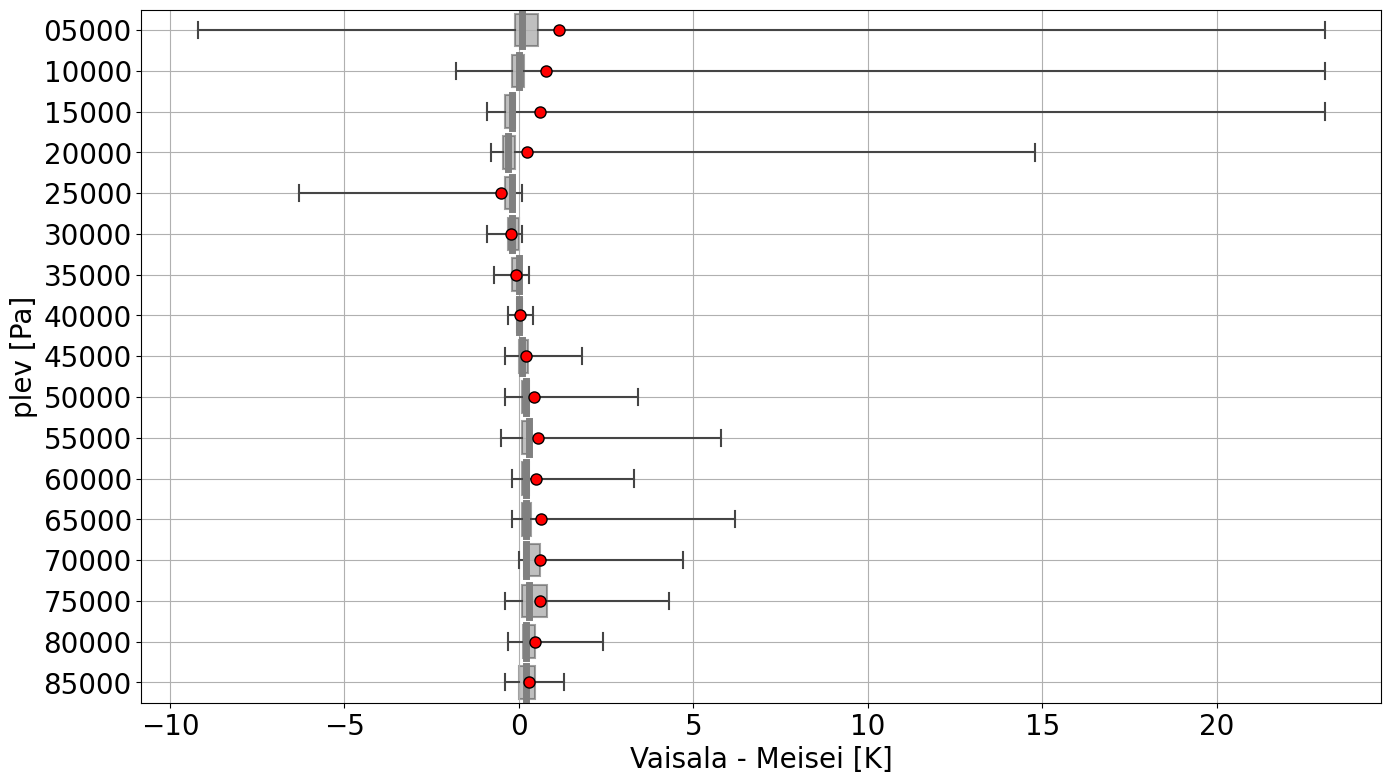

In [15]:
df_in = pd.DataFrame.from_dict(out)
df_in.plev = df_in.plev.str.zfill(5)
df_in = df_in.sort_values(by="plev")

for i in zip(
    [
        "Difference",
    ],
    ["grey"],
):
    ax = seaborn.boxplot(
        data=df_in,
        x=i[0],
        y="plev",
        notch=False,
        showcaps=True,
        # fliersize = 100,
        showfliers=True,
        dodge=False,
        showmeans=True,
        boxprops={"facecolor": i[1], "alpha": 0.5},
        medianprops={"color": i[1], "linewidth": 5},
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
        whis=np.inf,
        # whis=1.5,
    )
    ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
    plt.grid()
    plt.show()
    plt.close()


In [16]:
# ax = seaborn.histplot(df_diff, label='Vaisala - Meisei', kde=True)
# ax.set(xlabel="Adjustments")
# ax.set(title='temperature difference to Vaisala sonde')
# plt.legend()
# plt.show()

## 2010 intercomparison 

In [17]:
table = pd.read_csv('./table3685.csv')
interc = pd.read_csv('./wmo_intercomparison_2010.csv')

In [19]:
for i in interc.sonde_id.drop_duplicates():
    print(table[table.tac_code == i].description)

Series([], Name: description, dtype: object)
Series([], Name: description, dtype: object)
40    Graw DFM-06 (Germany)
Name: description, dtype: object
Series([], Name: description, dtype: object)
Series([], Name: description, dtype: object)
27    Sprenger E085 (Germany)                                                   
79    Vaisala RS41 with pressure derived from GPS height/DigiCORA MW41 (Finland)
Name: description, dtype: object
29    AIR IS - 4A - 1680 (United States)
81    NanJing Daqiao XGP-3G (China)*    
Name: description, dtype: object
85    Meisei RS2-91 (Japan)
Name: description, dtype: object
Series([], Name: description, dtype: object)
56    Vaisala RS80 /Autosonde (Finland)
Name: description, dtype: object
60    Sippican MARK II with chip thermistor, carbon element and derived pressure from GPS height
Name: description, dtype: object
11    Mesural FMO 1950A (France)          
45    Vaisala RS41/DigiCORA MW41 (Finland)
Name: description, dtype: object
12    Mesural FMO 194

In [20]:
len(interc.sonde_code.drop_duplicates()), len(interc.sonde_id.drop_duplicates()), len(interc.sonde_name.drop_duplicates())

(13, 15, 10)

In [21]:
data_cleaned = {}
plevs = {}


for asc in np.sort(glob.glob('/users/staff/uvoggenberger/CEUAS/CEUAS/public/intercomparisons/DATA/Vaisala/*')):
    try:
        ascentnr = asc[-3:]
        for i in glob.glob('/users/staff/uvoggenberger/CEUAS/CEUAS/public/intercomparisons/DATA/*/*.'+ascentnr):
            text = open(i, "r", encoding= 'unicode_escape')
            # display(text)

            #join() method combines all contents of 
            # csvfile.csv and formed as a string
            text = ''.join([j for j in text]) 

            # search and replace the contents
            text = text.replace("\t", ",") 
            text = re.sub(" +", ",", text)
            # output.csv is the output file opened in write mode
            x = open('./'+i.split('/')[-1],"w")

            # all the replaced text is written in the output.csv file
            x.writelines(text)
            x.close()

        yang_dfs = []
        for i in glob.glob('./*.'+ascentnr):
            df = pd.read_csv(i, delimiter=',', header=0, encoding= 'unicode_escape')
            # print(i)
            yang_dfs.append(df)

        labels = glob.glob('./*.'+ascentnr)
        compare_to = labels.index([s for s in labels if "Vaisala" in s][0])
        # print(compare_to)

        yang_dfs[compare_to].Pressure = pd.to_numeric(yang_dfs[compare_to].Pressure, errors='coerce')
        yang_dfs[compare_to] = yang_dfs[compare_to].dropna(subset = ['Pressure'])
        yang_dfs[compare_to].Temperature = pd.to_numeric(yang_dfs[compare_to].Temperature, errors='coerce')
        yang_dfs[compare_to] = yang_dfs[compare_to].dropna(subset = ['Temperature'])
        
        for plev_to_check in range(50, 900, 50):
            cp_to = yang_dfs[compare_to][yang_dfs[compare_to].Pressure == find_nearest(yang_dfs[compare_to].Pressure, plev_to_check)]

            for sonde in range(len(labels)):
                label = labels[sonde][2:].split('.')[0]
                if sonde == compare_to:
                    continue

                yang_dfs[sonde].Pressure = pd.to_numeric(yang_dfs[sonde].Pressure, errors='coerce')
                yang_dfs[sonde] = yang_dfs[sonde].dropna(subset = ['Pressure'])
                yang_dfs[sonde].Temperature = pd.to_numeric(yang_dfs[sonde].Temperature, errors='coerce')
                yang_dfs[sonde] = yang_dfs[sonde].dropna(subset = ['Temperature'])

                for press in range(len(cp_to)):
                    delta_t = (
                        cp_to.Temperature.iloc[press]
                        - yang_dfs[sonde][
                            yang_dfs[sonde].Pressure
                            == find_nearest(
                                np.array(yang_dfs[sonde].Pressure),
                                cp_to.Pressure.iloc[press]
                            )
                        ].Temperature.values[0]
                    )
                if label in list(data_cleaned.keys()):
                    data_cleaned[label].append(delta_t)
                    plevs[label].append(str(plev_to_check))
                else:
                    data_cleaned[label]=[delta_t]
                    plevs[label]=[str(plev_to_check)]

    except:
        print('error')
    

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


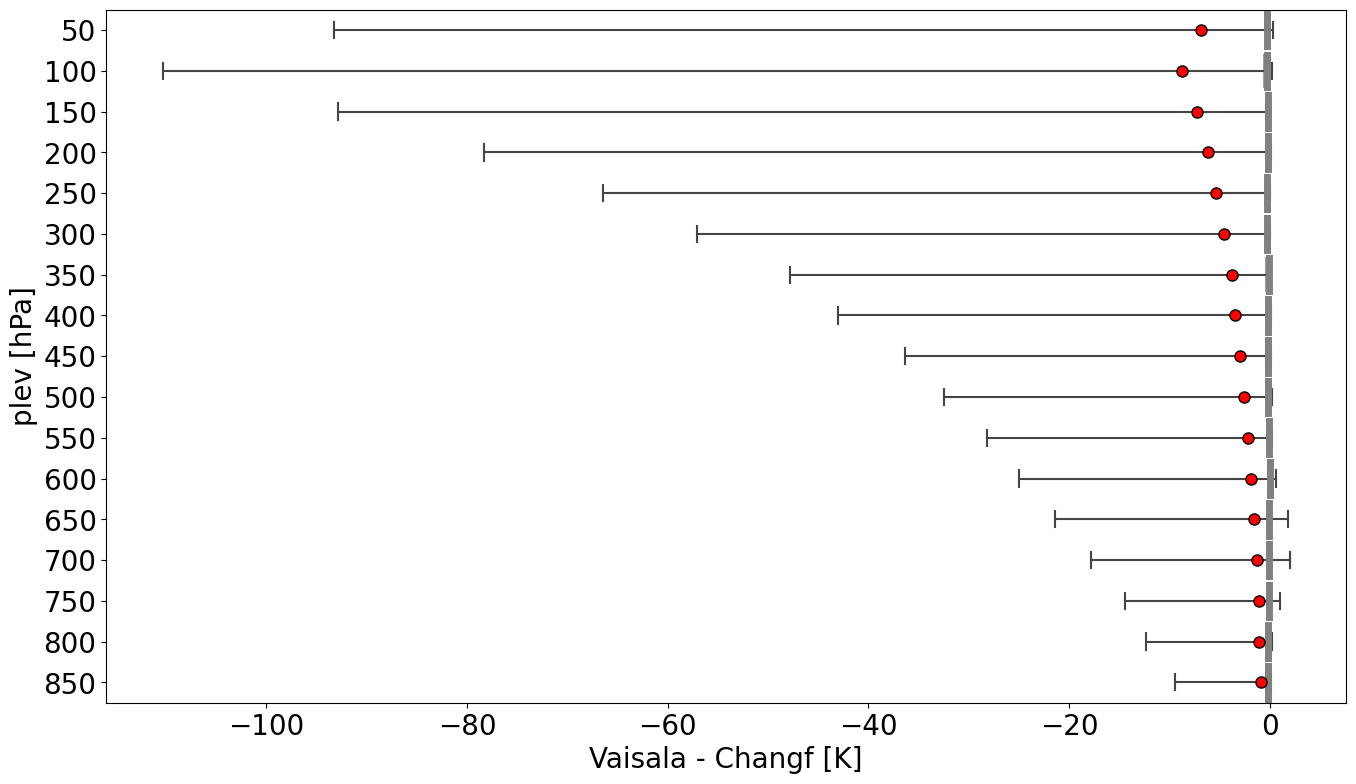

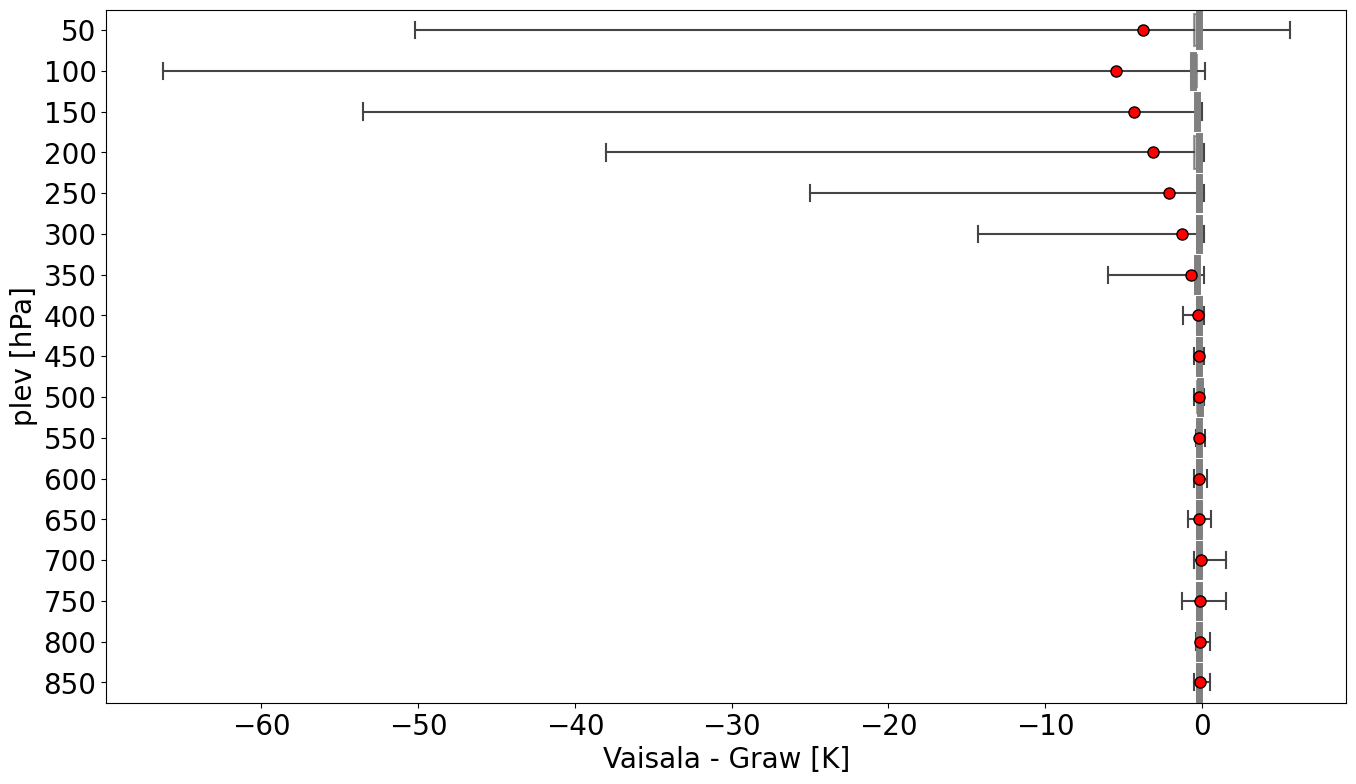

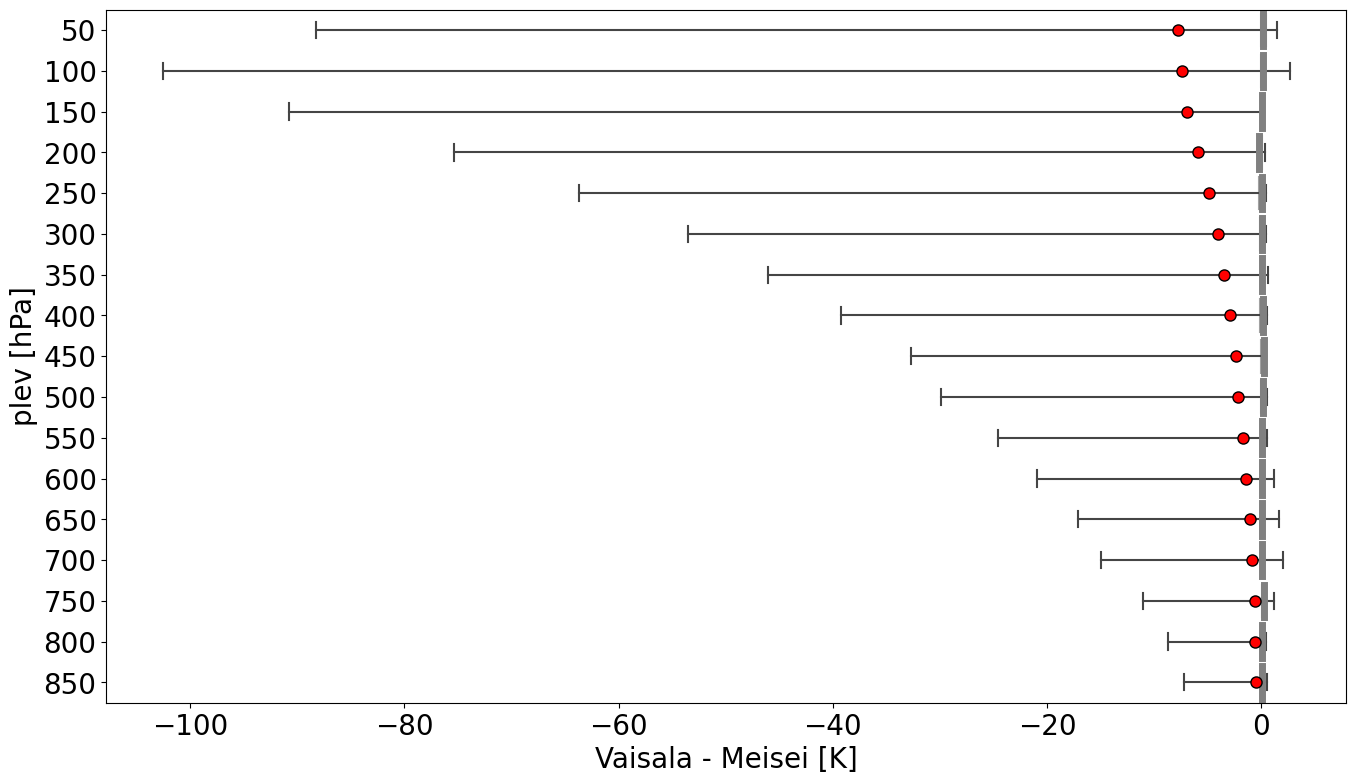

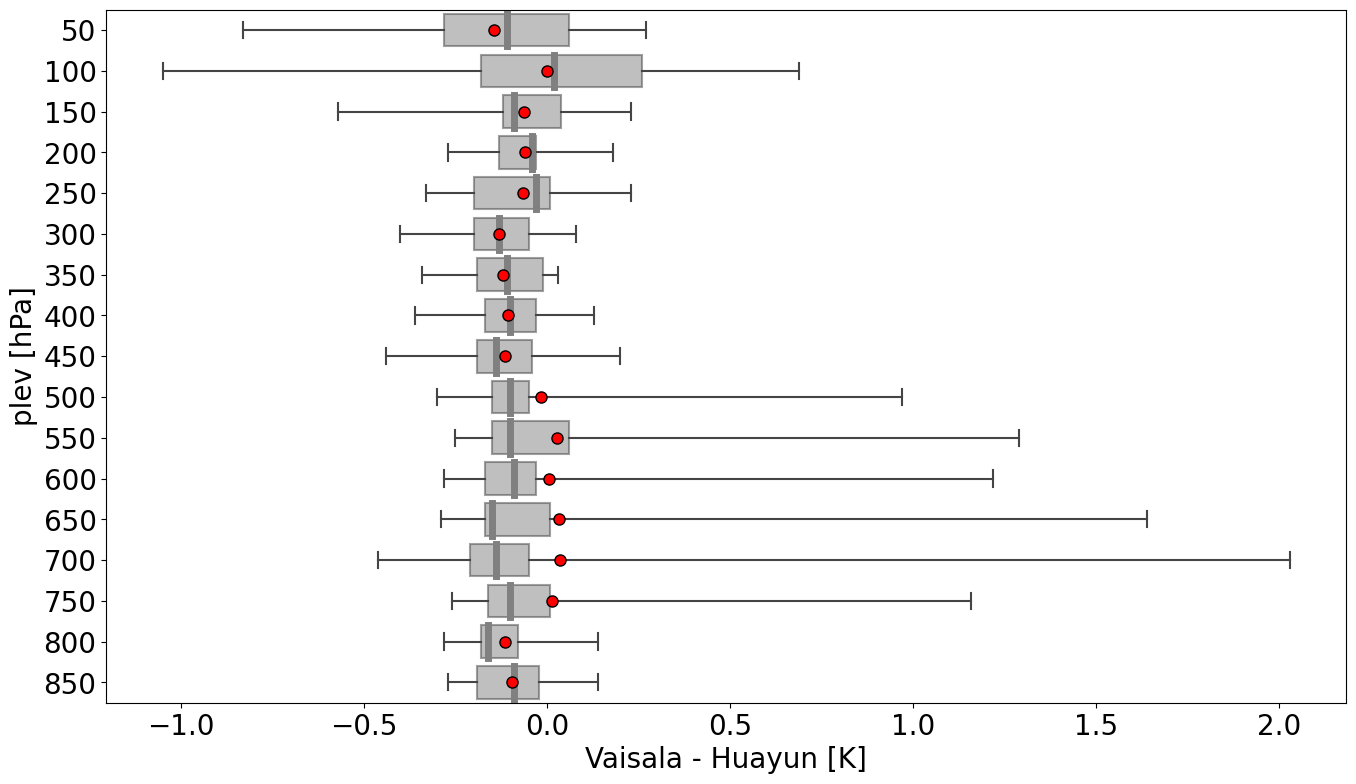

In [22]:
try: labels.remove('./Vaisala.069')
except: pass
for i in labels:
    label = i[2:].split(".")[0]
    seaborn.boxplot(
        x=data_cleaned[label],
        y=plevs[label],
        notch=False,
        showcaps=True,
        showfliers=True,
        dodge=False,
        boxprops={"facecolor": "grey", "alpha": 0.5},
        medianprops={"color": "grey", "linewidth": 5},
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
        showmeans =  True, 
        whis=np.inf,
        # whis=1.5,
    ).set(xlabel='Vaisala - ' + label + ' [K]', ylabel="plev [hPa]")
    plt.show()
    plt.close()